In [61]:
%cd /workspace/

import json

import lm_eval
import torch
import torch.nn.functional as F
from lm_eval.api.model import LM
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from model import GPT, GPTConfig
from tokenizer import HfTokenizerWrapper, SpaceTokenizer, unpack_token
from tokenizers import Tokenizer
    
# lm_eval --model hf --model_args pretrained=openai-community/gpt2 --tasks hellaswag --device cuda:0 --batch_size 8

/workspace


/root/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [62]:
class LMWrapper(LM):
    def __init__(self, tokenizer, model, device='cuda', TRAIN_SPACE=True):
        super().__init__()
        self.device = device
        self.TRAIN_SPACE = TRAIN_SPACE
        self.tokenizer = tokenizer
        self.model = model.to(self.device)

    def loglikelihood(self, requests, disable_tqdm: bool = False):
        return [self.calculate_loglikelihood(req.arguments[0], req.arguments[1]) for req in tqdm(requests, disable=disable_tqdm)]

    def calculate_loglikelihood(self, context, continuation):
        input_text = context + continuation
        inputs = self.tokenizer.encode(input_text)
        inputs = torch.tensor(inputs, dtype=torch.long).unsqueeze(0).to(self.device)
        model_inputs = inputs[:, :-1]

        continuation_ids = self.tokenizer.encode(continuation)
        continuation_ids = torch.tensor(continuation_ids, dtype=torch.long).unsqueeze(0).to(self.device)

        with torch.no_grad():
            ret = self.model(model_inputs)
            logits = ret[0] if isinstance(ret, tuple) else ret.logits # get logits from nanoGPT/hf model

        if self.TRAIN_SPACE:
            continuation_ids = unpack_token(continuation_ids)[0]

        continuation_length = continuation_ids.size(-1)
        continuation_logits = logits[:, -continuation_length:]
        loss = F.cross_entropy(continuation_logits.view(-1, continuation_logits.size(-1)), continuation_ids.view(-1), reduction="sum")
        log_likelihood = -loss.item()

        greedy_ids = torch.argmax(continuation_logits, dim=-1)
        is_greedy = torch.equal(greedy_ids, continuation_ids)
        
        return (log_likelihood, is_greedy)

    def generate_until(self, requests):
        raise NotImplementedError()
    
    def loglikelihood_rolling(self, requests):
        raise NotImplementedError()

In [ ]:
def create_lm_hf_ref():
    tokenizer = AutoTokenizer.from_pretrained('gpt2')
    model = AutoModelForCausalLM.from_pretrained('gpt2')
    return LMWrapper(tokenizer, model, device="cuda", TRAIN_SPACE=False)


def create_lm_ref_20k():
    model = GPT(GPTConfig(vocab_size=20000 + 257), TRAIN_SPACE=False)
    model.load_state_dict(torch.load("./model_ref_20k.pt", weights_only=False)["model"])

    tokenizer = HfTokenizerWrapper(Tokenizer.from_file("./tokenizer-ref-20k.json"))
    return LMWrapper(tokenizer, model, device="cuda", TRAIN_SPACE=False)


def create_lm_ref_50k():
    model = GPT(GPTConfig(vocab_size=50000 + 257), TRAIN_SPACE=False)
    model.load_state_dict(torch.load("./model_ref_50k.pt", weights_only=False)["model"])

    tokenizer = AutoTokenizer.from_pretrained('gpt2')
    return LMWrapper(tokenizer, model, device="cuda", TRAIN_SPACE=False)


def create_lm_space():
    model = GPT(GPTConfig(vocab_size=20000 + 257), TRAIN_SPACE=True)
    model.load_state_dict(torch.load("./model_space_20k.pt", weights_only=False)["model"])

    with open('./tokenizer-space-20k-rs.json', 'r', encoding='utf-8') as f: tokenizer_config = json.load(f)
    tokenizer = SpaceTokenizer(tokenizer_config)
    return LMWrapper(tokenizer, model, device="cuda", TRAIN_SPACE=True)

models = {
    "hf-50k": create_lm_hf_ref(),
    "ref-50k": create_lm_ref_50k(),
    "ref-20k": create_lm_ref_20k(),
    "space-20k": create_lm_space()
}

results = {}
for name, model in models.items():
    task_manager = lm_eval.tasks.TaskManager()
    model_result = lm_eval.simple_evaluate(
        model=model,
        # "hellaswag", "piqa", "arc_easy", "winogrande", "lambada_openai"
        tasks=["hellaswag", "piqa", "arc_easy", "winogrande", "lambada_openai"],
        task_manager=task_manager,
        num_fewshot=None,
        limit=None,
    )

    print(name)
    print(model_result["results"])
    results[name] = model_result["results"]

    with open("eval.json", "w") as json_file:
        json.dump(results, json_file, indent=4)

model             hf-50k   ref-20k space-20k
measure              acc       acc       acc
task                                        
arc_easy        0.438131  0.510522  0.539141
hellaswag       0.289185  0.288289  0.295857
lambada_openai  0.325636  0.222783  0.232292
piqa            0.628945  0.616975  0.630033


<Figure size 1000x600 with 0 Axes>

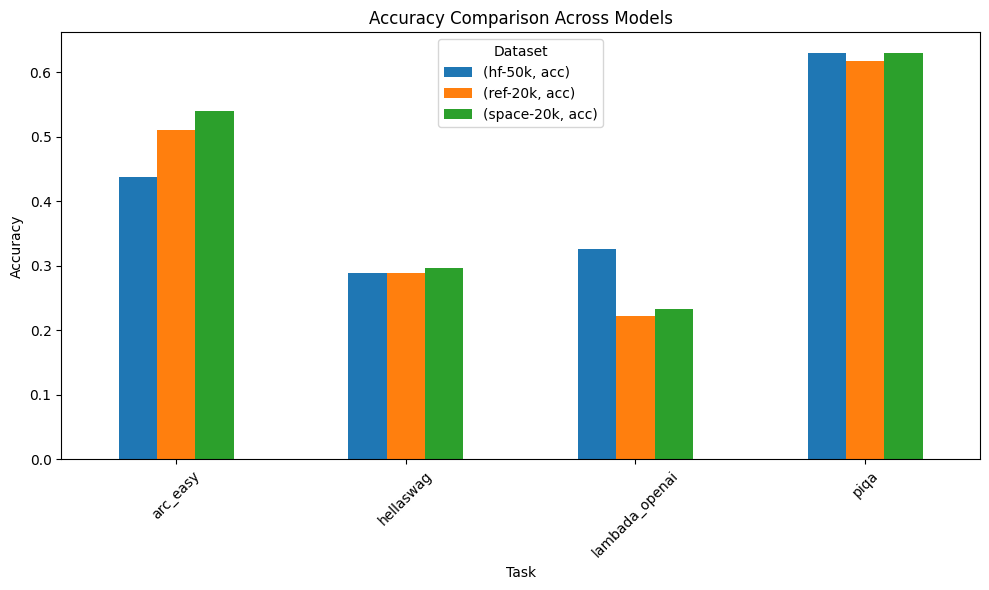

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import json

pd.set_option('display.max_colwidth', 200)

with open('/workspace/eval.json', 'r') as file:
    data = json.load(file)

df = pd.json_normalize(data, sep='|').T
df.reset_index(inplace=True)
df.columns = ['metric', 'value']

df['metric'] = df['metric'].str.replace(',none', '')

df[['model', 'task', 'measure']] = df['metric'].str.split('|', expand=True)
df = df.drop(columns='metric')

df = df[~df['model'].isin(['ref-50k'])]
df = df[~df['task'].isin(['winogrande'])]
df = df[df['measure'].isin(['acc'])]

accuracy_pivot = df.pivot(index='task', columns=['model', 'measure'], values='value')
# print(accuracy_df)
print(accuracy_pivot)

plt.figure(figsize=(10, 6))
accuracy_pivot.plot(kind='bar', figsize=(10, 6), rot=45)
plt.title('Accuracy Comparison Across Models')
plt.ylabel('Accuracy')
plt.xlabel('Task')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()